In this notebook, we will use _Tunax_ to calibrate a subset of the parameters of the closure $k-\varepsilon$ using a subset of the database of LES that Gregory Wagner used in his paper on the calibration of the closure CATKE [1]. The subset of parameters that we will calibrate are the ones which influence the equation of $\varepsilon$. They are noted as $c_{\varepsilon_1}, c_{\varepsilon_2}, c_{\varepsilon_3^-}$ and $c_{\varepsilon_3^+}$ in [2]. The subset of the LES that we will use is the 7 simulations in the condition of free-convection.

# Database
The 7 LES that we will use are extracted from the database of Wagner [1]. These simulations all have a space resolution of 1m. These simulations are done on 7 different timeframe with 7 different forcing so that for each one the mixing length is about 100m at the end of the simulation.

### Visualisation of one simulation
One can choose in the code below the simulation of the set of Wagner to visualize.

In [38]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

timeframe_list = [6, 12, 18, 24, 36, 48, 72]
space_step_list = [0.75, 1, 2, 4]
forcing_list = ['free_convection', 'med_wind_med_cooling', 'strong_wind', 'strong_wind_no_rotation', 'strong_wind_weak_cooling', 'weak_wind_strong_cooling']

timeframe = timeframe_list[-1]
space_step = space_step_list[1]
forcing = forcing_list[4]
filename = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
filename_yaml = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

if os.path.exists(filename):
    ds = xr.open_dataset(filename)
else:
    print("simulation doesn't exit")
ds

<xarray.Dataset> Size: 22MB
Dimensions:  (t: 433, zw: 257, zr: 256)
Coordinates:
  * t        (t) float64 3kB 0.0 600.0 1.2e+03 ... 2.58e+05 2.586e+05 2.592e+05
  * zw       (zw) float64 2kB -256.0 -253.7 -251.4 -249.2 ... -1.539 -0.7697 0.0
  * zr       (zr) float64 2kB -254.9 -252.6 -250.3 ... -1.924 -1.155 -0.3848
Data variables: (12/25)
    Ri       (t, zw) float64 890kB ...
    T        (t, zr) float64 887kB ...
    TT       (t, zr) float64 887kB ...
    b        (t, zr) float64 887kB ...
    bT       (t, zr) float64 887kB ...
    e        (t, zr) float64 887kB ...
    ...       ...
    wv       (t, zw) float64 890kB ...
    ww       (t, zw) float64 890kB ...
    KdzT     (t, zw) float64 890kB ...
    mudzu    (t, zw) float64 890kB ...
    mudzv    (t, zw) float64 890kB ...
    mudzw    (t, zr) float64 887kB ...

In [40]:
500/8000000

6.25e-05

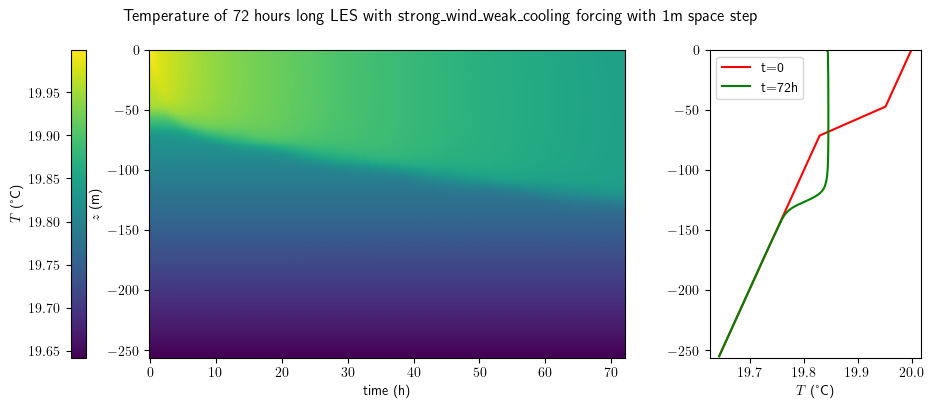

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)

time = ds.t/3600
X, Y = np.meshgrid(time, ds.zr)

fig = plt.figure(figsize=(12, 4))
plt.tight_layout()
[gs_2D, gs_1D] = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax_2D = fig.add_subplot(gs_2D)
ax_1D = fig.add_subplot(gs_1D, sharey=ax_2D)

pcm = ax_2D.pcolormesh(X, Y, ds.T.transpose(), shading='nearest')
fig.colorbar(pcm, ax=ax_2D, label='$T$ (°C)', location='left')
ax_2D.set_xlabel('time (h)')
ax_2D.set_ylabel('$z$ (m)')

ax_1D.plot(ds.T[0, :], ds.zr, 'r', label='t=0')
ax_1D.plot(ds.T[-1, :], ds.zr, 'g', label=f't={int(time[-1])}h')
ax_1D.set_xlabel('$T$ (°C)')
ax_1D.legend()

fig.suptitle(f'Temperature of {timeframe} hours long LES with {forcing} forcing with {space_step}m space step')
plt.show()

### Visualization of all the simulations
Here we can visualize all the simulations in free-convection.

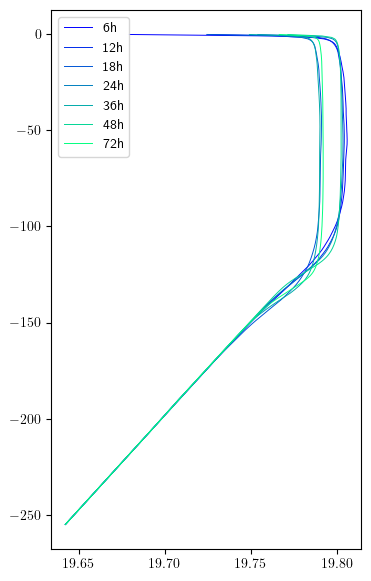

In [78]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(4, 7))
colors = cm.winter(np.linspace(0, 1, 7))
for i, timeframe in enumerate(timeframe_list):
    filename = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', '1m', 'free_convection_instantaneous_statistics.nc')
    ds = xr.open_dataset(filename)
    plt.plot(ds.T[-1, :], ds.zr, color=colors[i], linewidth=0.7, label=f'{timeframe}h')
plt.legend()

# Importation as a database

In [11]:
import jax.numpy as jnp
from jax import lax

def lmd_swfrac(Hz):
    """
    Compute fraction of solar shortwave flux penetrating to specified depth due
    to exponential decay in Jerlov water type.

    Parameters
    ----------
    Hz : float(N)
        layer thickness [m]

    Returns
    -------
    swr_frac : float(N+1)
        fraction of solar penetration
    """
    # returned variables
    N, = Hz.shape
    mu1 = 0.35
    mu2 = 23.0
    r1 = 0.58
    attn1 = -1.0 / mu1
    attn2 = -1.0 / mu2

    xi1 = attn1 * Hz
    xi2 = attn2 * Hz

    def step(sdwk, k):
        sdwk1, sdwk2 = sdwk
        sdwk1 = lax.cond(xi1[N-k] > -20, lambda x: x*jnp.exp(xi1[N-k]),
                             lambda x: 0.*x, sdwk1)
        sdwk2 = lax.cond(xi2[N-k] > -20, lambda x: x*jnp.exp(xi2[N-k]),
                             lambda x: 0.*x, sdwk2)
        return (sdwk1, sdwk2), sdwk1+sdwk2
    
    _, swr_frac = lax.scan(step, (r1, 1.0 - r1), jnp.arange(1, N+1))
    return jnp.concat((swr_frac[::-1], jnp.array([1])))

Hz = jnp.ones(10)

lmd_swfrac(Hz)

Array([0.27191025, 0.2839932 , 0.2966131 , 0.30979377, 0.3235602 ,
       0.33793867, 0.3529617 , 0.36874962, 0.38693422, 0.43544132,
       1.        ], dtype=float32, weak_type=True)

In [4]:
var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    
}
from database import Obs

obs = Obs(filename, filename_yaml, var_names)

In [23]:
ds.T

<xarray.DataArray 'T' (t: 73, zr: 64)> Size: 37kB
array([[19.654949, 19.663876, 19.672325, ..., 19.992151, 19.995291, 19.99843 ],
       [19.654949, 19.663876, 19.672325, ..., 19.992151, 19.995291, 19.950737],
       [19.654949, 19.663876, 19.672325, ..., 19.992151, 19.995291, 19.903046],
       ...,
       [19.655003, 19.663845, 19.672369, ..., 19.805447, 19.797832, 19.769552],
       [19.655003, 19.663849, 19.672375, ..., 19.80393 , 19.796219, 19.76792 ],
       [19.655001, 19.663851, 19.67238 , ..., 19.802341, 19.794636, 19.765558]])
Coordinates:
  * t        (t) float64 584B 0.0 600.0 1.2e+03 ... 4.2e+04 4.26e+04 4.32e+04
  * zr       (zr) float64 512B -251.5 -242.8 -234.5 ... -7.698 -4.618 -1.539

# References
1. Wagner GL. et al. Formulation and calibration of CATKE, a one-equation parameterization for microscale ocean mixing. Journal of Advances in Modeling Earth Systems (submitted). 2024. https://arxiv.org/abs/2306.13204
2. Burchard, H., and K. Bolding. Comparative Analysis of Four Second-Moment Turbulence Closure Models for the Oceanic Mixed Layer. Journal of Physical Oceanography, 31, 1943–1968. 2001. https://doi.org/10.1175/1520-0485(2001)031<1943:CAOFSM>2.0.CO;2. 